Author: Harshal Bhasgauri


Link to Dataset: https://www.kaggle.com/datasets/pavelbiz/eyes-rtte

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from sklearn.utils import resample
import os
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:
dir = 'C:/Users/harsh/OneDrive/Documents/AIDI/AIDI1009 NN/projects/Project 3/ruskino_data'

label = []
path = []

for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        label.append(os.path.split(dirname)[1])
        path.append(os.path.join(dirname,filename))

In [3]:
df = pd.DataFrame(columns=['Image','Label'])
df['Image']=path
df['Label']=label

In [4]:
df = shuffle(df)
df = df.reset_index(drop=True)

# Exploratory data analysis

In [5]:
len(df)

10001

In [6]:
df.head()

,Image,Label
0,C:/Users/harsh/OneDrive/Documents/AIDI/AIDI100...,femaleeyes
1,C:/Users/harsh/OneDrive/Documents/AIDI/AIDI100...,maleeyes
2,C:/Users/harsh/OneDrive/Documents/AIDI/AIDI100...,maleeyes
3,C:/Users/harsh/OneDrive/Documents/AIDI/AIDI100...,maleeyes
4,C:/Users/harsh/OneDrive/Documents/AIDI/AIDI100...,femaleeyes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   10001 non-null  object
 1   Label   10001 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [8]:
df.describe()

,Image,Label
count,10001,10001
unique,10001,2
top,C:/Users/harsh/OneDrive/Documents/AIDI/AIDI100...,femaleeyes
freq,1,5202


There are total of 10001 Images in the entire dataset, having 2 labels [maleeyes, femaleeyes]. Frequency of femaleeyes is greater then frequency of maleeyes.

In [9]:
#checking for null
df.isna().sum()

Image    0
Label    0
dtype: int64

No null values in the dataset

femaleeyes    5202
maleeyes      4799
Name: Label, dtype: int64


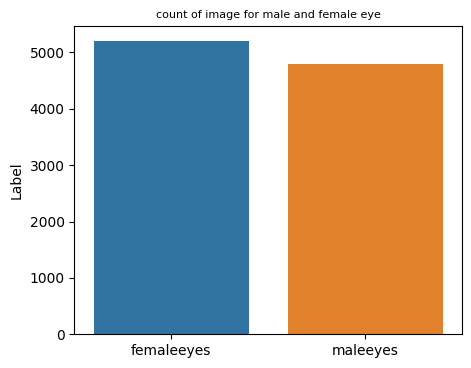

In [10]:
# Count number of samples for each category [Male, Female]
bp = df['Label'].value_counts()
print(bp)

plt.figure(figsize = (5, 4))
sns.barplot(x = bp.index, y = bp)
plt.title("count of image for male and female eye", fontsize = 8)
plt.show()

It is clear from the graph that there is an imbalance in the training dataset. I will now perform downsampling to balance the dataset. I am not suing data augmentation as database is too large.

In [11]:
# Define the paths to the male and female eye image folders
male_path = 'C:/Users/harsh/OneDrive/Documents/AIDI/AIDI1009 NN/projects/Project 3/ruskino_data/maleeyes'
female_path = 'C:/Users/harsh/OneDrive/Documents/AIDI/AIDI1009 NN/projects/Project 3/ruskino_data/femaleeyes'

# Count the number of images in each folder
num_male_images = len(os.listdir(male_path))
num_female_images = len(os.listdir(female_path))

# Determine the size of the minority class
min_class_size = min(num_male_images, num_female_images)
print(min_class_size)


4799


In [12]:
df_male = df[df.Label=='maleeyes']
df_female = df[df.Label=='femaleeyes'] #femaleeyes need to be downsampled

In [13]:
#downsampling without replacing
df_down_sample = resample(df_female, replace=False, n_samples=4799, random_state=42)

In [14]:
# Combine both samples
df = pd.concat([df_down_sample, df_male])
df = shuffle(df)
df = df.reset_index(drop=True)

In [15]:
# Display count of data points in both class
print(df.Label.value_counts())

df.describe()

maleeyes      4799
femaleeyes    4799
Name: Label, dtype: int64


,Image,Label
count,9598,9598
unique,9598,2
top,C:/Users/harsh/OneDrive/Documents/AIDI/AIDI100...,maleeyes
freq,1,4799


maleeyes      4799
femaleeyes    4799
Name: Label, dtype: int64


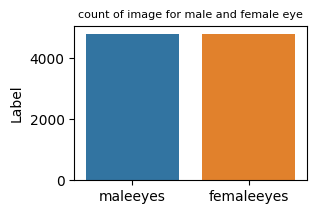

In [16]:
ds = df['Label'].value_counts()

print(ds)
plt.figure(figsize = (3, 2))
sns.barplot(x = ds.index, y = ds)
plt.title("count of image for male and female eye", fontsize = 8)
plt.show()

Now we have a balanced data set.

Changing all image dimensions to (64x64) and converting to grayscale

In [18]:
size = (64,64)

dfcopy = df.copy() #duplicating original dataframe

size_list = set()
for i in range(len(df)):
    image=cv2.imread(df['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    size_list.add(image.shape)
    dfcopy['Image'][i] = image.flatten()

size_list #printing the new image dimension

{(64, 64, 3)}

In [20]:
dfcopy.head()

,Image,Label
0,"[118, 80, 57, 118, 80, 58, 113, 76, 57, 106, 7...",maleeyes
1,"[201, 139, 102, 198, 136, 99, 196, 134, 97, 19...",femaleeyes
2,"[186, 138, 126, 186, 138, 126, 186, 136, 125, ...",maleeyes
3,"[234, 186, 166, 232, 185, 165, 232, 185, 166, ...",femaleeyes
4,"[240, 171, 156, 241, 172, 157, 239, 166, 151, ...",femaleeyes


In [21]:
labelEnc = LabelEncoder()
dfcopy['Label'] = np.asarray(labelEnc.fit_transform(dfcopy['Label']))#femaleeyes as 0 and maleeyes as 1

In [22]:
dfcopy.head()

,Image,Label
0,"[118, 80, 57, 118, 80, 58, 113, 76, 57, 106, 7...",1
1,"[201, 139, 102, 198, 136, 99, 196, 134, 97, 19...",0
2,"[186, 138, 126, 186, 138, 126, 186, 136, 125, ...",1
3,"[234, 186, 166, 232, 185, 165, 232, 185, 166, ...",0
4,"[240, 171, 156, 241, 172, 157, 239, 166, 151, ...",0


# Implementing SVM Classification Model(Benchmark Model)

In [23]:
images = []
labels = []

for label, path in enumerate([male_path, female_path]):
    for file in os.listdir(path):
        image = np.array(Image.open(os.path.join(path, file)).resize((64, 64)))
        images.append(image)
        labels.append(label)

In [24]:
# Convert the images and labels to numpy arrays
X = np.array(images)
y = np.array(labels)

In [25]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
# Reshaping the training and testing data because SVM expects 2D array
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [27]:
#Defining SVM classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [28]:
# Make predictions on the testing data
y_pred = svm.predict(X_test)

In [29]:
# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of SVM model: {accuracy:.2f}')

Accuracy of SVM model: 0.79


[[1144  326]
 [ 300 1231]]


Text(0.5, 1.0, 'Accuracy Score: 0.7914028657114295')

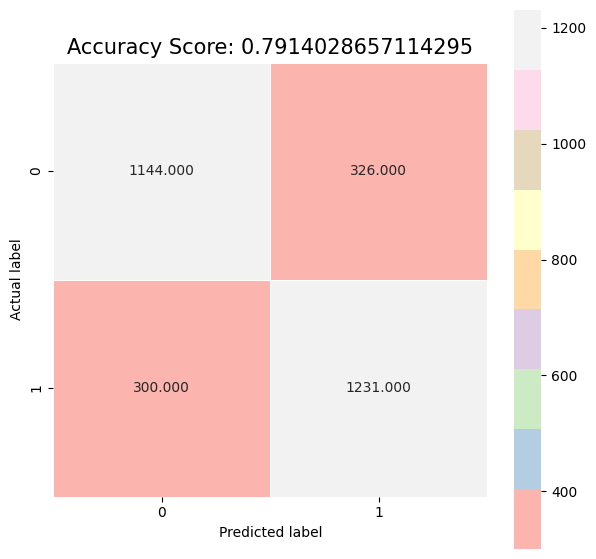

In [30]:
# Generating the confusion matrix
confusionmatrix = confusion_matrix(y_test, y_pred)

# Printing the confusion matrix
print(confusionmatrix)

#Plot the confusion matrix
plt.figure(figsize=(7,7))
sns.heatmap(confusionmatrix,annot=True, fmt='.3f', linewidths=.5, square=True,cmap="Pastel1")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title,size=15)

<!-- Here I can see from confusion matrix that our SVM classifier has an accuracy of 79.14%, where from 3001 samples, the algorithm correctly identified 840 samples as True Positive, 901 as True Negatives, 193 as False Positive and 147 as False Negatives. -->

In [31]:
# Print the classification report
SVM_Classification_report = classification_report(y_test, y_pred)
print(SVM_Classification_report)

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1470
           1       0.79      0.80      0.80      1531

    accuracy                           0.79      3001
   macro avg       0.79      0.79      0.79      3001
weighted avg       0.79      0.79      0.79      3001



SVM Model gives an average precision of 79%, recall of 79% and f1-score and accuracy of about 0.79.

# Multilayer Perceptron Model

creating train, test and Validation set

In [32]:
# creating a funtion that will reshape the arrray and reset index 
def cleaned(X):
    for i in range(len(X)):
        X[i] = np.vstack(X[i].reset_index(drop=True))
    return X

dividing df for train, test and validation set

In [33]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(dfcopy.Image, dfcopy.Label,
                                                      test_size = 0.4, random_state = 7)
X_val2, X_test2,y_val2, y_test2 = train_test_split(X_val2, y_val2, test_size = 0.5, random_state = 7)

In [34]:
x_train2, x_val2, x_test2, y_train2, y_val2, y_test2 = cleaned([X_train2, X_val2, X_test2, y_train2, y_val2, y_test2])

In [35]:
#printing X array shapes
print("X_Train: ", x_train2.shape) 
print("X_Val: ", x_val2.shape) 
print("X_Test: ", x_test2.shape) 

X_Train:  (5758, 12288)
X_Val:  (1920, 12288)
X_Test:  (1920, 12288)


In [36]:
#printing y array shapes
print("y_Train: ", y_train2.shape) 
print("y_Val: ", y_val2.shape) 
print("y_test: ", y_test2.shape)

y_Train:  (5758, 1)
y_Val:  (1920, 1)
y_test:  (1920, 1)


Model architechture

Here I am designing a model architechture. Here I am using Leaky Relu and sigmoid activation functions. Leaky Relu is similar to ReLU, but instead of returning 0 for negative inputs, it returns a small negative value. This will help me to address the "dying ReLU" problem, where ReLU neurons can become permanently inactive during training.

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

The first layer is a dense layer with 1024 units and a leaky rectified linear unit (leaky_relu) activation function, and takes the input data as input. I have then added a dropout layer with a dropout rate of 0.5 to prevent overfitting. adding another dense layer with 512 units and a leaky_relu activation function, followed by another dropout layer. Finally, we add a dense layer with 1 unit and a sigmoid activation function, which will outputs the predicted class probabilities(as 0 or 1).

I am using this model architechture because because it has multiple layers of neurons with nonlinear activation functions, which allows it to learn complex patterns in the data while preventing overfitting.

Calculating weight of classes. this is important for training.

In [38]:
male = len(y_train2[y_train2>0])
female = len(y_train2) - male
total = len(y_train2)

In [39]:
weight_for_male = total / (2 * male) 
weight_for_female = total / (2 * female)
class_weight = {0: weight_for_female, 1: weight_for_male}
print(class_weight)

{0: 0.9920744314266023, 1: 1.0080532212885154}


compiling the model using the binary cross-entropy loss function and the adam optimizer, and specifying that i want to track the accuracy, precision, recall and auc metric during training

In [40]:
model.compile(
    optimizer='adam', loss='binary_crossentropy',
    metrics=[
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
    ]
)

Training my MLP model

In [41]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train2)

In [42]:
model_fit = model.fit(x_train_scaled, y_train2, class_weight=class_weight, batch_size=64,
                validation_data=(x_val2, y_val2),
                epochs=25)

Epoch 1/25
90/90 [==============================] - 12s 122ms/step - loss: 7.4883 - accuracy: 0.7079 - precision: 0.7016 - recall: 0.7153 - auc: 0.7281 - val_loss: 2673.6997 - val_accuracy: 0.5115 - val_precision: 0.5112 - val_recall: 1.0000 - val_auc: 0.5005
Epoch 2/25
90/90 [==============================] - 11s 120ms/step - loss: 4.0842 - accuracy: 0.7800 - precision: 0.7756 - recall: 0.7829 - auc: 0.8057 - val_loss: 225.8261 - val_accuracy: 0.6911 - val_precision: 0.9470 - val_recall: 0.4190 - val_auc: 0.6997
Epoch 3/25
90/90 [==============================] - 11s 121ms/step - loss: 2.4604 - accuracy: 0.8001 - precision: 0.7941 - recall: 0.8060 - auc: 0.8363 - val_loss: 214.5239 - val_accuracy: 0.6240 - val_precision: 0.9675 - val_recall: 0.2732 - val_auc: 0.6323
Epoch 4/25
90/90 [==============================] - 11s 121ms/step - loss: 1.7198 - accuracy: 0.8102 - precision: 0.8053 - recall: 0.8141 - auc: 0.8540 - val_loss: 234.3708 - val_accuracy: 0.6307 - val_precision: 0.5818 - 

Making predictions on my MLP model

In [43]:
x_test_scaled = scaler.fit_transform(x_test2)

In [44]:
y_pred2 = model.predict(x_test_scaled)
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)
y_pred2

60/60 [==============================] - 1s 7ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

Plotting training and testing loss

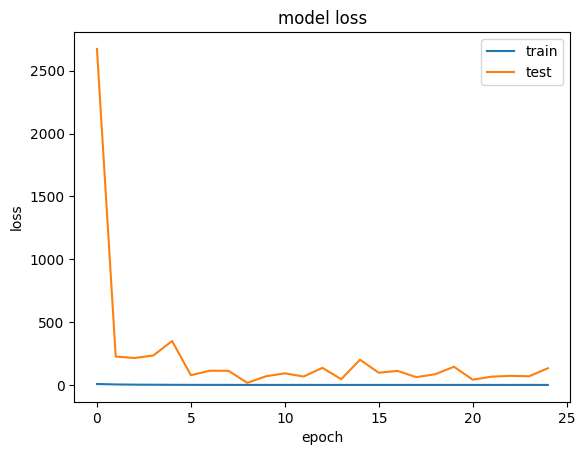

In [46]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Plotting training and testing accuracy

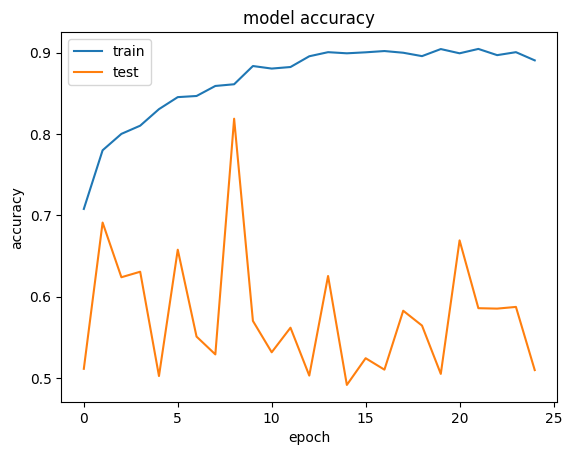

In [47]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('model accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Classification report for my MLP model

In [48]:
model_classification_report = classification_report(y_test2,y_pred2)
print(model_classification_report)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       958
           1       0.91      0.86      0.88       962

    accuracy                           0.89      1920
   macro avg       0.89      0.89      0.89      1920
weighted avg       0.89      0.89      0.89      1920



# Convolutional Neural network

In [49]:
# creating a helper function
def to_tensor(_list):
    LIST = []
    for i in range(len(_list)):
        LIST.append(tf.convert_to_tensor(_list[i]))
    return LIST

In [50]:
# creating a new function to reshape the array adn reset index 
def cleaned2(X):
    for i in range(len(X)):
        X[i] = np.stack(X[i].reset_index(drop=True))
    return X

In [51]:
# Convert image path to array of image using cv2
size = (64,64)
dfcopy2 = df.copy()

for i in range(len(df)):
    image=cv2.imread(df['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dfcopy2['Image'][i] = image

In [52]:
labelencoder = LabelEncoder()
dfcopy2['Label'] = np.asarray(labelencoder.fit_transform(dfcopy2["Label"]))
display(dfcopy2.head())

,Image,Label
0,"[[[118, 80, 57], [118, 80, 58], [113, 76, 57],...",1
1,"[[[201, 139, 102], [198, 136, 99], [196, 134, ...",0
2,"[[[186, 138, 126], [186, 138, 126], [186, 136,...",1
3,"[[[234, 186, 166], [232, 185, 165], [232, 185,...",0
4,"[[[240, 171, 156], [241, 172, 157], [239, 166,...",0


In [53]:
dfcopy2.Image[1].shape

(64, 64, 3)

creating a train, test and validation set

In [54]:
x_train3, x_val3, y_train3, y_val3 = train_test_split(dfcopy2.Image, dfcopy2.Label,
                                                      test_size = 0.4, random_state = 7)
x_val3, x_test3, y_val3, y_test3 = train_test_split(x_val3, y_val3, test_size = 0.5, random_state = 7)

x_train3, x_val3, x_test3, y_train3, y_val3, y_test3 = cleaned2([x_train3, x_val3, x_test3,
                                                                 y_train3, y_val3, y_test3])
x_train3, x_val3, x_test3, y_train3, y_val3, y_test3 = to_tensor([x_train3, x_val3, x_test3,
                                                                  y_train3, y_val3, y_test3])

printing shapes of new sets

In [55]:
print("X Train: ", x_train3.shape) 
print("X Val: ", x_val3.shape) 
print("X Test: ", x_test3.shape) 
print("y Train: ", y_train3.shape) 
print("y Val: ", y_val3.shape) 
print("y test: ", y_test3.shape) 

X Train:  (5758, 64, 64, 3)
X Val:  (1920, 64, 64, 3)
X Test:  (1920, 64, 64, 3)
y Train:  (5758,)
y Val:  (1920,)
y test:  (1920,)


creating a model architechture for CNN

In [56]:
myCNNmodel=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')  
])

I am using a common model architechture for image classification tasks, as it includes several convolutional layers that can extract high-level features from the input image, followed by pooling layers that reduce the spatial dimensions of the feature maps. The batch normalization layers can help stabilize training, and the dropout layers can help prevent overfitting. The final fully connected layer with a sigmoid activation function can produce a binary classification output. Overall, this architecture has a good balance between model complexity and performance on a wide range of image classification tasks.

compiling the model

In [57]:
myCNNmodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [58]:
cnn_model_fit=myCNNmodel.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=25)

Epoch 1/25
180/180 [==============================] - 16s 76ms/step - loss: 0.6321 - accuracy: 0.7004 - val_loss: 0.7750 - val_accuracy: 0.5823
Epoch 2/25
180/180 [==============================] - 13s 74ms/step - loss: 0.3722 - accuracy: 0.8394 - val_loss: 0.3619 - val_accuracy: 0.8432
Epoch 3/25
180/180 [==============================] - 13s 72ms/step - loss: 0.3140 - accuracy: 0.8730 - val_loss: 0.3007 - val_accuracy: 0.8771
Epoch 4/25
180/180 [==============================] - 13s 73ms/step - loss: 0.2809 - accuracy: 0.8887 - val_loss: 0.3453 - val_accuracy: 0.8646
Epoch 5/25
180/180 [==============================] - 13s 73ms/step - loss: 0.2548 - accuracy: 0.8949 - val_loss: 0.3157 - val_accuracy: 0.8786
Epoch 6/25
180/180 [==============================] - 13s 72ms/step - loss: 0.2252 - accuracy: 0.9139 - val_loss: 0.2790 - val_accuracy: 0.8833
Epoch 7/25
180/180 [==============================] - 13s 72ms/step - loss: 0.2008 - accuracy: 0.9220 - val_loss: 0.2516 - val_accuracy:

plotting training and validation loss

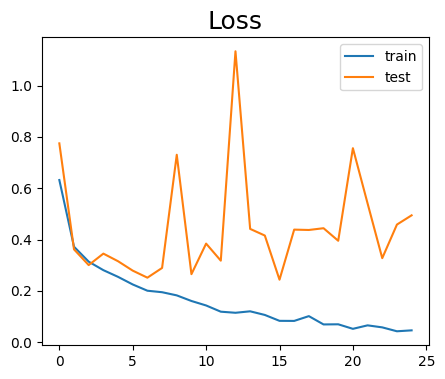

In [59]:
plt.figure(figsize=(5,4))
plt.plot(cnn_model_fit.history['loss'])
plt.plot(cnn_model_fit.history['val_loss'])
plt.title('Loss',fontdict={'size':18})
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plotting training and validation accuracy

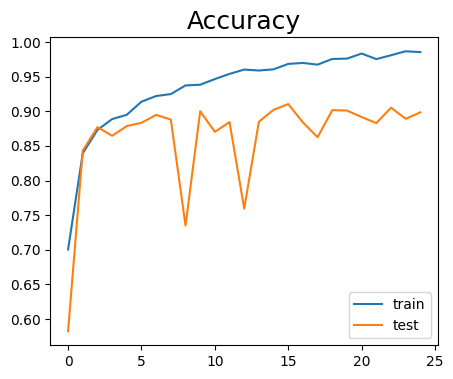

In [60]:
plt.figure(figsize=(5,4))
plt.plot(cnn_model_fit.history['accuracy'])
plt.plot(cnn_model_fit.history['val_accuracy'])
plt.title('Accuracy',fontdict={'size':18})
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Making predicitons on cnn model

In [61]:
y_pred_myCNN = myCNNmodel.predict(x_test3)
y_pred_myCNN = np.round(y_pred_myCNN)

60/60 [==============================] - 1s 17ms/step


In [62]:
recall_myCNN = recall_score(y_test3, y_pred_myCNN)
precision_myCNN = precision_score(y_test3, y_pred_myCNN)
f1_myCNN = f1_score(y_test3, y_pred_myCNN)
roc_myCNN = roc_auc_score(y_test3, y_pred_myCNN)

creating a classification report

In [67]:
myCNN_Classification_Report = classification_report(y_test3, y_pred_myCNN)
print(myCNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.91      0.86      0.89       958
           1       0.87      0.92      0.89       962

    accuracy                           0.89      1920
   macro avg       0.89      0.89      0.89      1920
weighted avg       0.89      0.89      0.89      1920



The overall accuracy of the model on the testing set is 87%, which is a good performance. The precision and recall scores are also high for both classes (0 and 1), which means that the model is able to correctly identify both classes with high accuracy.
the model is performing well and is able to correctly identify the classes with high accuracy. 

Printing classification report for all three model

In [64]:
print('this was my benchmark model SVM')
print(SVM_Classification_report)

this was my benchmark model SVM
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1470
           1       0.79      0.80      0.80      1531

    accuracy                           0.79      3001
   macro avg       0.79      0.79      0.79      3001
weighted avg       0.79      0.79      0.79      3001



In [65]:
print('this is MLP model')
print(model_classification_report)

this is MLP model
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       958
           1       0.91      0.86      0.88       962

    accuracy                           0.89      1920
   macro avg       0.89      0.89      0.89      1920
weighted avg       0.89      0.89      0.89      1920



In [66]:
print('this is my CNN model')
print(myCNN_Classification_Report)

this is my CNN model
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       958
           1       0.87      0.92      0.89       962

    accuracy                           0.89      1920
   macro avg       0.89      0.89      0.89      1920
weighted avg       0.89      0.89      0.89      1920



# CONCLUSION

Looking at the precision, recall, and f1-score metrics, I can see that the CNN and MLP models are performing similarly and much better than the SVM model. The CNN model has a slightly higher precision for class 0, while the MLP model has a slightly higher precision for class 1. Both models have a similar recall and f1-score for both classes.

Overall, the CNN and MLP models are performing better than the SVM model, with the CNN model having a slightly better performance. It's important to note that the performance of the models may vary depending on the specific dataset and problem at hand, so it's always recommended to try multiple models and compare their performances.